<a href="https://colab.research.google.com/github/gabrie1-s/phosphorus_analysis/blob/main/Analise_fosforo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Importing libraries and reading data

In [ ]:
%%capture
!pip install Bayesian-Optimization
!pip install xgboost
!pip install ray

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statistics
import math
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
import os
import gc
import pdb
import ray
import keras
import xgboost
import tensorflow
from scipy import stats
from sklearn import metrics
from xgboost import XGBRegressor
from keras.models import load_model
from bayes_opt import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go

In [ ]:
ray.init()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-05-08 01:25:31,603	INFO worker.py:1749 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.20.0


In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
fosforo = pd.read_excel("/content/drive/MyDrive/CNN_Chagas/fosforo/Dados_B1_B7.xlsx")

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
fosforo.columns = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'P']

In [ ]:
dataset = fosforo[fosforo.columns[:7]]

In [ ]:
target = fosforo['P']

# 2. Histograms / Skew

In [ ]:
df = dataset.copy()
df['P'] = target

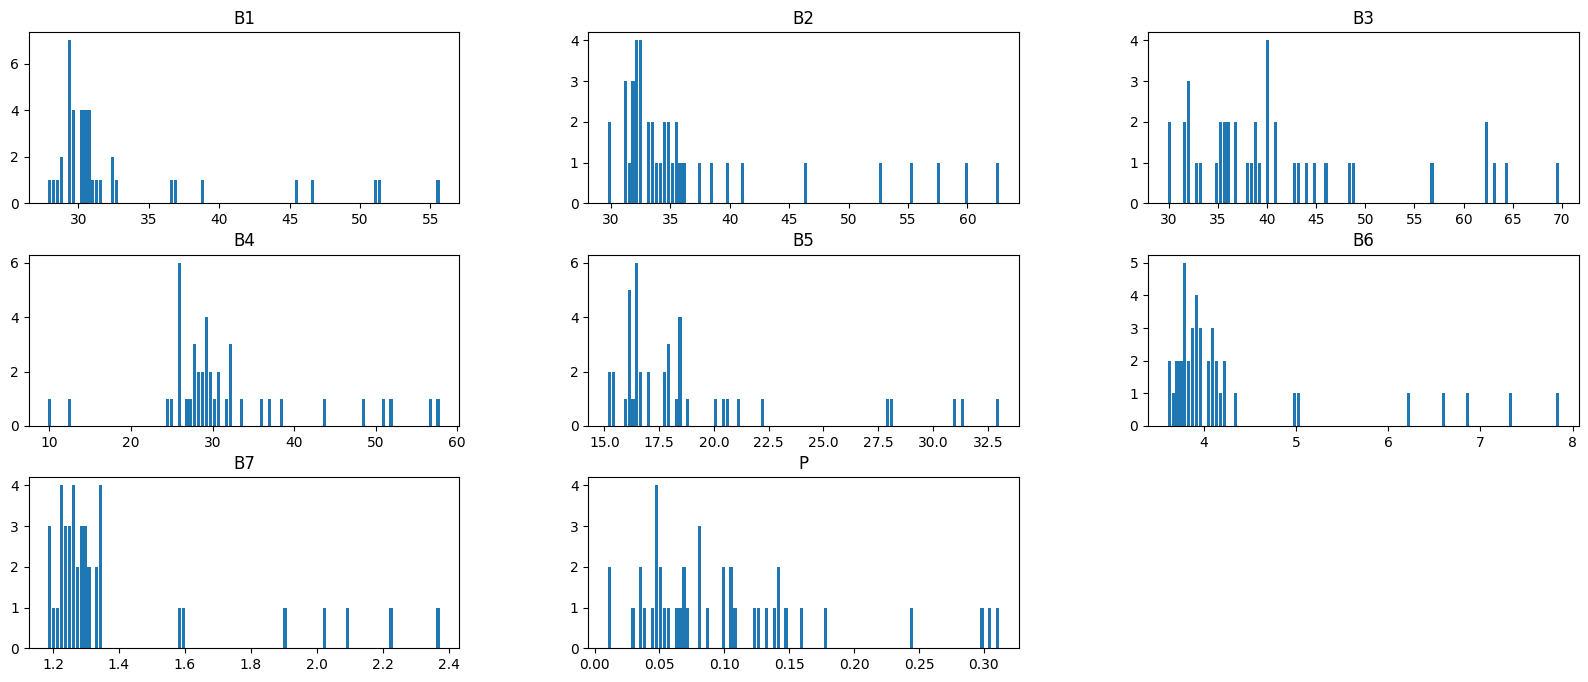

In [ ]:
df.hist(
    figsize=(20, 8),
    grid = False,
    rwidth = 0.8,
    bins = 100
)
plt.show()

In [ ]:
df.skew()

B1    2.202681
B2    2.021795
B3    1.406842
B4    0.991740
B5    2.011601
B6    2.300812
B7    2.306189
P     1.565691
dtype: float64

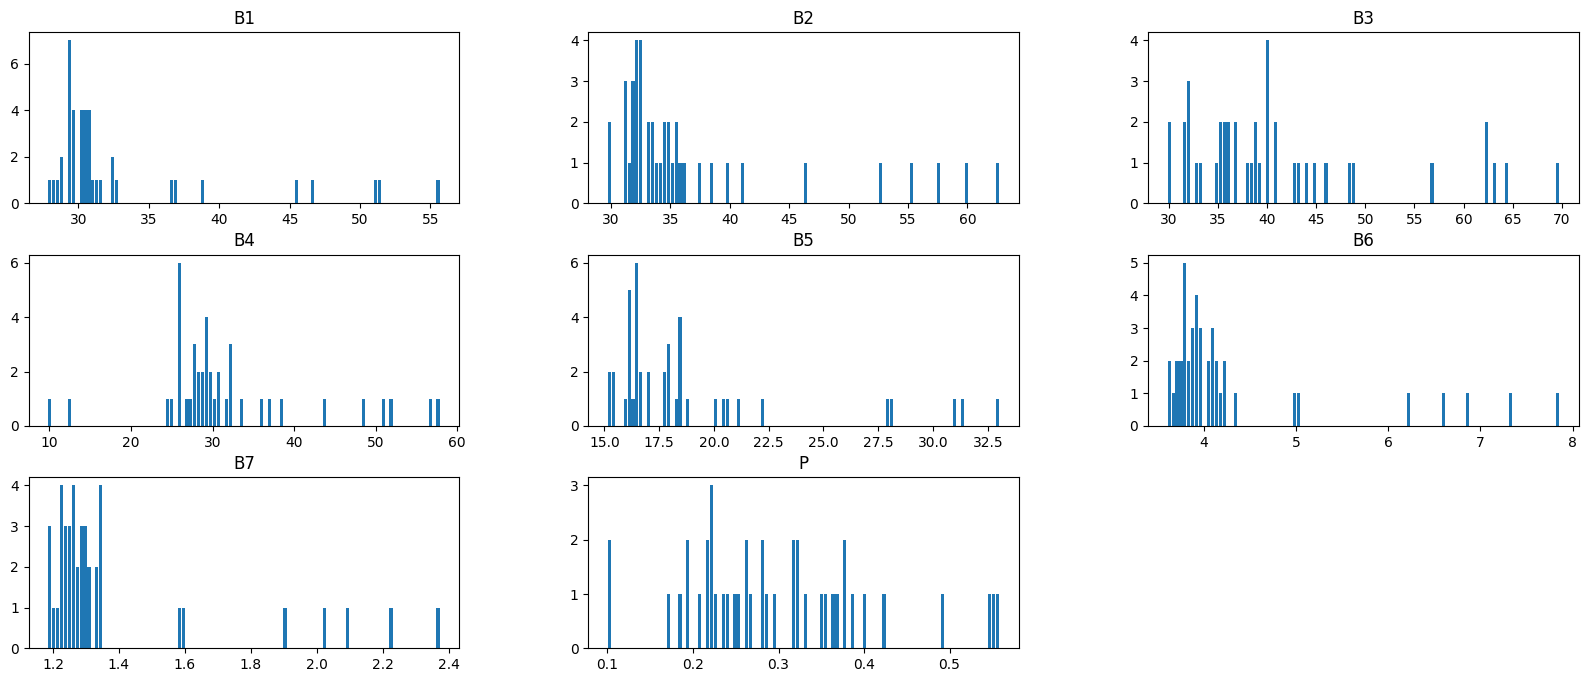

In [ ]:
lbs = []

for col in df.columns:
  if abs(df.skew()[col]) > 0.9:
    _, l = stats.boxcox(df[col])[0:2]
    lbs.append(l)

target = np.sqrt(target)
df['P'] = target

df.hist(
    figsize=(20, 8),
    grid = False,
    rwidth = 0.8,
    bins = 100
)
plt.show()

In [ ]:
lbs

[-6.756821209151582,
 -4.911524211710275,
 -2.1109315692577852,
 0.4495494212091018,
 -4.232461187722476,
 -5.997571733575384,
 -7.043710808407542,
 0.199055449196808]

In [ ]:
df.skew()

B1    2.202681
B2    2.021795
B3    1.406842
B4    0.991740
B5    2.011601
B6    2.300812
B7    2.306189
P     0.712777
dtype: float64

In [ ]:
dataset = df[df.columns[:7]]
target = df['P']

# 3. Boxplots

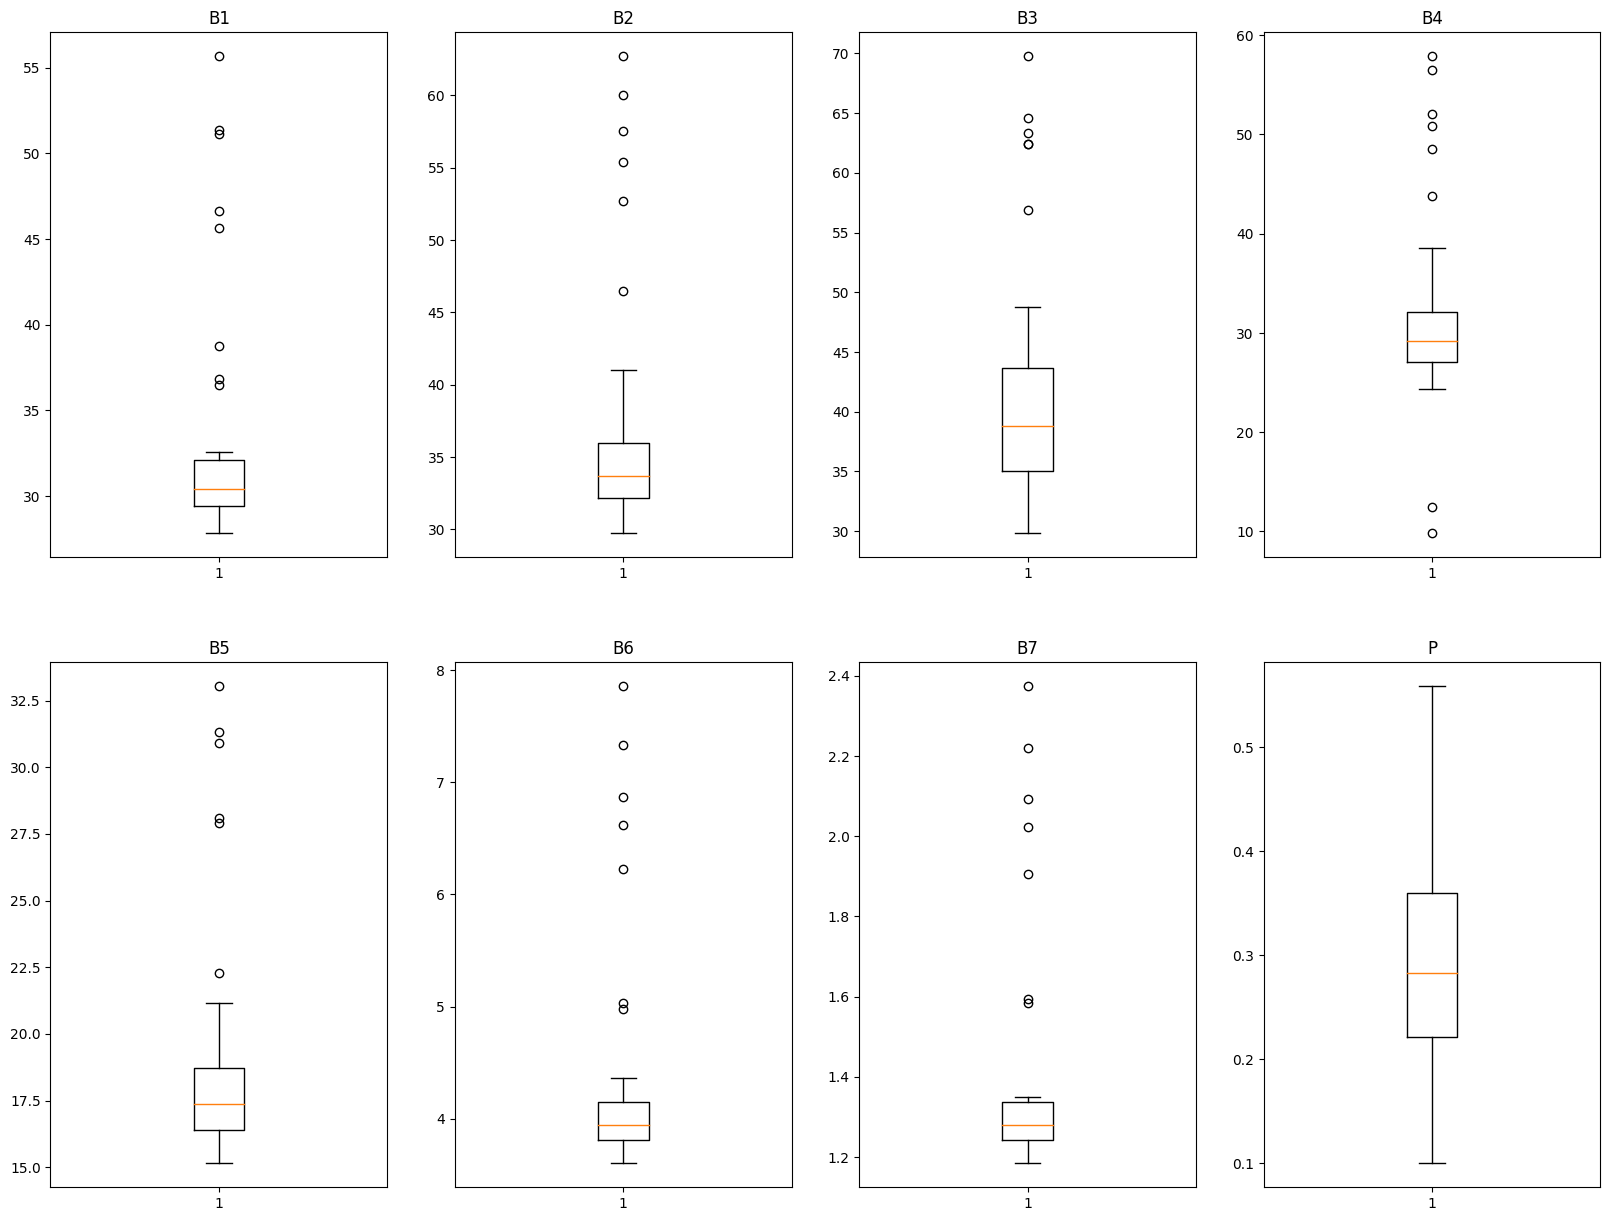

In [ ]:
i=0
j=0

df = dataset.copy()
df['P'] = target

plt.rcParams["figure.figsize"] = (20,15)
fig, axs = plt.subplots(2, 4)
for col in df.columns:
  axs[i,j].set_title(col)
  axs[i,j].boxplot(df[col])
  j +=1

  if j > 3:
    j = 0
    i +=1

plt.show()

# 4. Outliers Removal

In [ ]:
def outliers_treatment(dataset, target, method='remotion', median_p_dist=0.1, target_dist=0.1):
  if method == 'median':
    for i, p1 in enumerate(target):
      similar = [i]
      for j, p2 in enumerate(target):
        if abs(p1-p2) < target_dist*p1:
          similar.append(j)

      for k in range(len(dataset.columns)):
        for j in similar:
          if abs(dataset.iloc[i, k] - dataset.iloc[j, k]) > median_p_dist*dataset.iloc[i, k]:
            dataset.iloc[i, k] = statistics.median([dataset.iloc[c, k] for c in similar])
            dataset.iloc[j, k] = statistics.median([dataset.iloc[c, k] for c in similar])


  elif method == 'remotion':
    to_drop = []
    for i, p1 in enumerate(target):
      similar = [i]
      for j, p2 in enumerate(target):
        if abs(p1-p2) < target_dist*p1:
          similar.append(j)

      for k in range(len(dataset.columns)):
        if abs(dataset.iloc[i, k] - statistics.median([dataset.iloc[c, k] for c in similar])) >  median_p_dist*dataset.iloc[i, k]:
          to_drop.append(i)
          break

    dataset = dataset.drop(index=to_drop)
    dataset.reset_index(drop=True, inplace=True)
    target = target.drop(index=to_drop)
    target.reset_index(drop=True, inplace=True)

  return dataset, target


In [ ]:
to_drop = [val for val in target.index if target[val] > 0.2]
dataset = dataset.drop(index=to_drop)
dataset.reset_index(drop=True, inplace=True)
target = target.drop(index=to_drop)
target.reset_index(drop=True, inplace=True)

In [ ]:
dataset, target = outliers_treatment(dataset, target, method='remotion', median_p_dist=0.15)

In [ ]:
dataset

# 5. Polynomial Relations

In [ ]:
for i in dataset.columns:
  dataset['bc('+str(i)+')'] = stats.boxcox(dataset[i])[0]

for i in dataset.columns:
  dataset['1/' + str(i)] = 1/dataset[i]

In [ ]:
dataset

,B1,B2,B3,B4,B5,B6,B7,bc(B1),bc(B2),bc(B3),bc(B4),bc(B5),bc(B6),bc(B7),1/B1,1/B2,1/B3,1/B4,1/B5,1/B6,1/B7,1/bc(B1),1/bc(B2),1/bc(B3),1/bc(B4),1/bc(B5),1/bc(B6),1/bc(B7)
0,29.5835,33.4172,40.1310,9.8038,17.8349,3.8763,1.2581,0.147999,0.203603,0.473529,3.982859,0.236268,0.166685,0.113798,0.033803,0.029925,0.024918,0.102001,0.056070,0.257978,0.794849,6.756821,4.911524,2.111802,0.251076,4.232483,5.999346,8.787533
1,29.5860,32.3914,36.8628,28.3816,16.6043,3.7379,1.2204,0.147999,0.203603,0.473491,7.785559,0.236268,0.166673,0.107064,0.033800,0.030872,0.027128,0.035234,0.060225,0.267530,0.819403,6.756821,4.911524,2.111973,0.128443,4.232490,5.999779,9.340167
2,30.1162,33.4923,38.7866,28.9411,17.8240,3.8617,1.2464,0.147999,0.203603,0.473515,7.873793,0.236268,0.166684,0.111881,0.033205,0.029858,0.025782,0.034553,0.056104,0.258953,0.802311,6.756821,4.911524,2.111867,0.127004,4.232483,5.999387,8.938059
3,29.4667,33.8746,40.8503,29.5920,17.6618,3.7854,1.2231,0.147999,0.203603,0.473536,7.975267,0.236268,0.166677,0.107604,0.033937,0.029521,0.024480,0.033793,0.056619,0.264173,0.817595,6.756821,4.911524,2.111770,0.125388,4.232484,5.999618,9.293368
4,30.6845,34.1537,38.8822,30.0438,18.4973,3.9169,1.2551,0.147999,0.203603,0.473516,8.044982,0.236268,0.166688,0.113320,0.032590,0.029279,0.025719,0.033285,0.054062,0.255304,0.796749,6.756821,4.911524,2.111862,0.124301,4.232480,5.999239,8.824582
5,45.6215,52.6813,62.4212,48.5056,28.0955,6.6208,2.0224,0.147999,0.203603,0.473648,10.512614,0.236269,0.166732,0.140976,0.021919,0.018982,0.016020,0.020616,0.035593,0.151039,0.494462,6.756821,4.911524,2.111274,0.095124,4.232464,5.997643,7.093418
6,30.6840,32.1027,32.9215,25.8750,16.4034,3.8543,1.2500,0.147999,0.203603,0.473428,7.378002,0.236267,0.166683,0.112486,0.032590,0.031150,0.030375,0.038647,0.060963,0.259450,0.800000,6.756821,4.911524,2.112254,0.135538,4.232492,5.999408,8.889978
7,29.3897,31.5916,33.0158,27.0334,16.5559,3.9747,1.2844,0.147999,0.203603,0.473430,7.568932,0.236268,0.166692,0.117618,0.034026,0.031654,0.030289,0.036991,0.060401,0.251591,0.778574,6.756821,4.911524,2.112246,0.132119,4.232491,5.999098,8.502097
8,28.7015,29.9586,29.8104,24.3255,15.1438,3.6037,1.1841,0.147999,0.203603,0.473359,7.115098,0.236267,0.166658,0.098792,0.034841,0.033379,0.033545,0.041109,0.066034,0.277493,0.844523,6.756821,4.911524,2.112563,0.140546,4.232504,6.000320,10.122309
9,30.1640,32.1973,32.1590,25.7599,16.1637,3.8129,1.2419,0.147999,0.203603,0.473413,7.358776,0.236267,0.166680,0.111105,0.033152,0.031059,0.031095,0.038820,0.061867,0.262268,0.805218,6.756821,4.911524,2.112321,0.135892,4.232494,5.999531,9.000521


In [ ]:
poly = PolynomialFeatures(degree=7, include_bias=False)
poly_features = poly.fit_transform(dataset)
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(dataset.columns))

# 6. Selection by Correlation

In [ ]:
def one_side_corr(data, target, method='spearman', target_corr=0.5, variables_corr=0.5):
    other_columns = [col for col in data.columns if col != target]
    values = []
    accepted_cols = []
    accepted_values = []
    for col in other_columns:
      corr_value = data[target].corr(data[col], method=method)
      if corr_value > target_corr:
        values.append((col, corr_value))

    values = sorted(values, key=lambda x: x[1], reverse=True)
    accepted_cols.append(values[0][0])
    accepted_values.append(values[0])

    for i in values:
      count = 0
      for col_acc in accepted_cols:
        if abs(data[col_acc].corr(data[i[0]], method=method)) > variables_corr:
          count += 1
          break
      if count == 0:
        accepted_cols.append(i[0])
        accepted_values.append(i)

    return accepted_values

In [ ]:
poly_df['P'] = target
poly_corr = one_side_corr(poly_df, 'P',method="spearman", target_corr=0.5, variables_corr=0.7)

In [ ]:
poly_corr

[('B5^3 1/B1^2 1/B7 1/bc(B7)', 0.7525531102671694),
 ('B2 B4 B6 1/B1 1/B7 1/bc(B4)^2', 0.6910358447105963),
 ('B2 B5^2 1/B1 1/bc(B3) 1/bc(B4) 1/bc(B7)', 0.6544010567902128),
 ('B2 B3 B5 bc(B6) 1/B6^3', 0.6383530744711068),
 ('B5^2 bc(B3) bc(B7) 1/B7^2 1/bc(B4)', 0.6243313525458273),
 ('B3 B5 B6 1/B1^2 1/B7 1/bc(B4)', 0.5594910199433786),
 ('B2 B3 bc(B7)^2 1/B6^2 1/bc(B4)', 0.5380937101845706),
 ('B3 B5 B7 1/B2 1/B6 1/bc(B7)^2', 0.5312044248455604),
 ('B2 B5 bc(B4)^2 1/B1 1/B4 1/B6', 0.5243961899223033),
 ('B5 B6^2 1/B1 1/bc(B6) 1/bc(B7)', 0.5183174087408238)]

In [ ]:
poly_df = poly_df[[x[0] for x in poly_corr]]

In [ ]:
y = target
x = poly_df

# 7.PCA

In [ ]:
# scaler = StandardScaler()
# x_scaled = scaler.fit_transform(x)
pca = PCA()
x_pca = pca.fit_transform(poly_df)

In [ ]:
cumulative_variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

val = list(range(1, len(cumulative_variance)+1))
fig = go.Figure(data=go.Scatter(x = val, y = cumulative_variance, mode='lines+markers'))
fig.update_layout(
    xaxis=dict(title='PCs', dtick=10 ,showgrid=True),
    yaxis=dict(title='Cumulative variance',  dtick=10, showgrid=True)
)
fig.show()

In [ ]:
x = pd.DataFrame()
y = target

for i, val in enumerate(np.transpose(x_pca[:, :41])[0:]):
  x['pc_' + str(i+1)] = val

# 8. Train/Test Split

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold

In [ ]:
def fold_visualizer(data, fold_idxs, seed_num):
    fig, axs = plt.subplots(len(fold_idxs)//2, 2, figsize=(15,(len(fold_idxs)//2)*5))
    fig.suptitle("Seed: " + str(seed_num), fontsize=16)
    for fold_id, (train_ids, val_ids) in enumerate(fold_idxs):
        sns.histplot(data=data[train_ids],
                     kde=True,
                     stat="density",
                     alpha=0.15,
                     label="Train Set",
                     bins=10,
                     line_kws={"linewidth":4},
                     ax=axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)])
        sns.histplot(data=data[val_ids],
                     kde=True,
                     stat="density",
                     color="darkorange",
                     alpha=0.15,
                     label="Validation Set",
                     bins=10,
                     line_kws={"linewidth":4},
                     ax=axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)])
        axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)].legend()
        axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)].set_title("Split " + str(fold_id+1))
    plt.show()

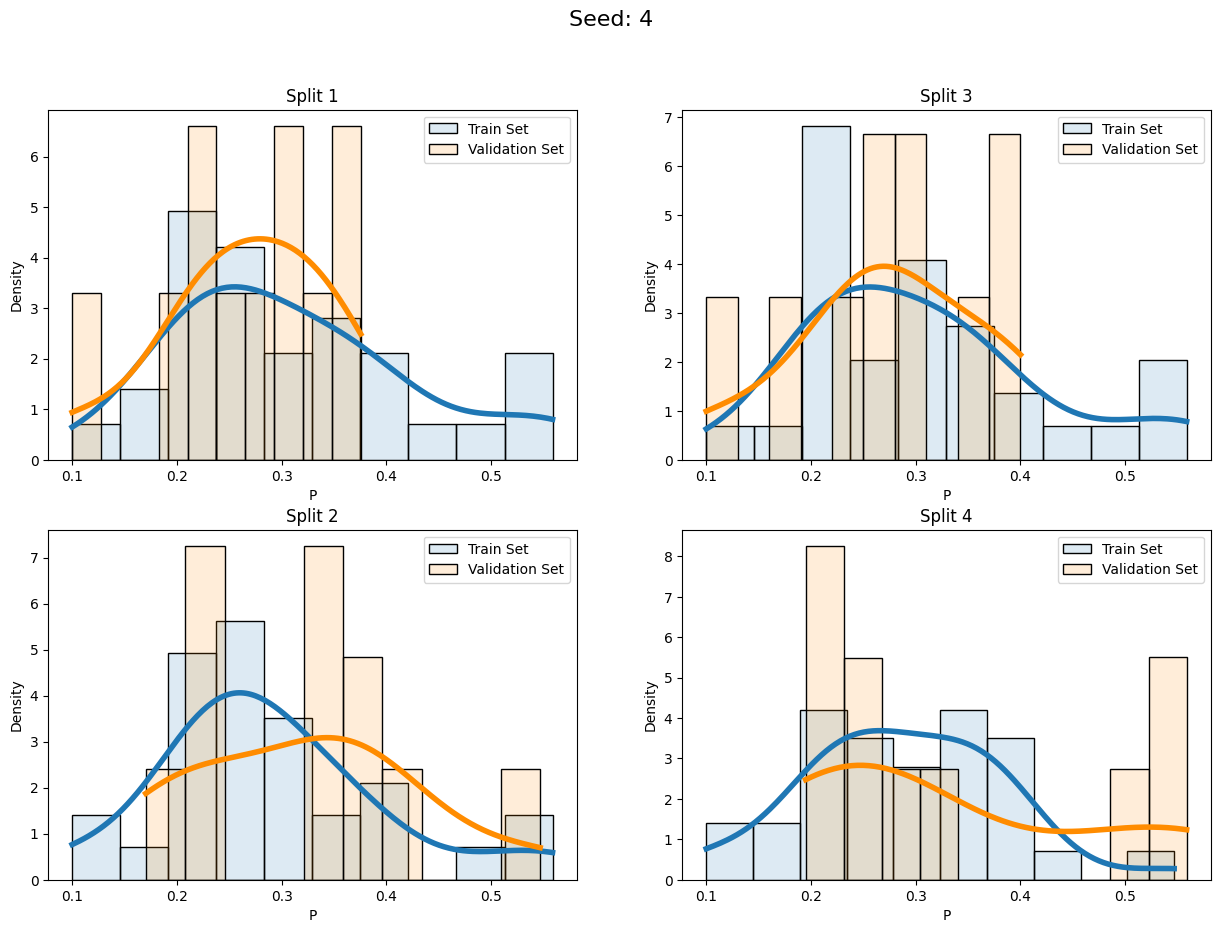

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)


baseline_kfold = list(KFold(4,
                            shuffle=True,
                            random_state=3
                            ).split(target))
fold_visualizer(data=target,
                fold_idxs=baseline_kfold,
                seed_num=4)

In [ ]:
def create_cont_folds(df, n_s=8, n_grp=10, seed=1):

    skf = StratifiedKFold(n_splits=n_s, shuffle=True, random_state=seed)
    grp = pd.cut(df, n_grp, labels=False)
    target = grp

    fold_nums = np.zeros(len(df))
    for fold_no, (t, v) in enumerate(skf.split(target, target)):
        fold_nums[v] = fold_no

    cv_splits = []

    for i in range(n_s):
        test_indices = np.argwhere(fold_nums==i).flatten()
        train_indices = list(set(range(len(df))) - set(test_indices))
        cv_splits.append((train_indices, test_indices))

    return cv_splits

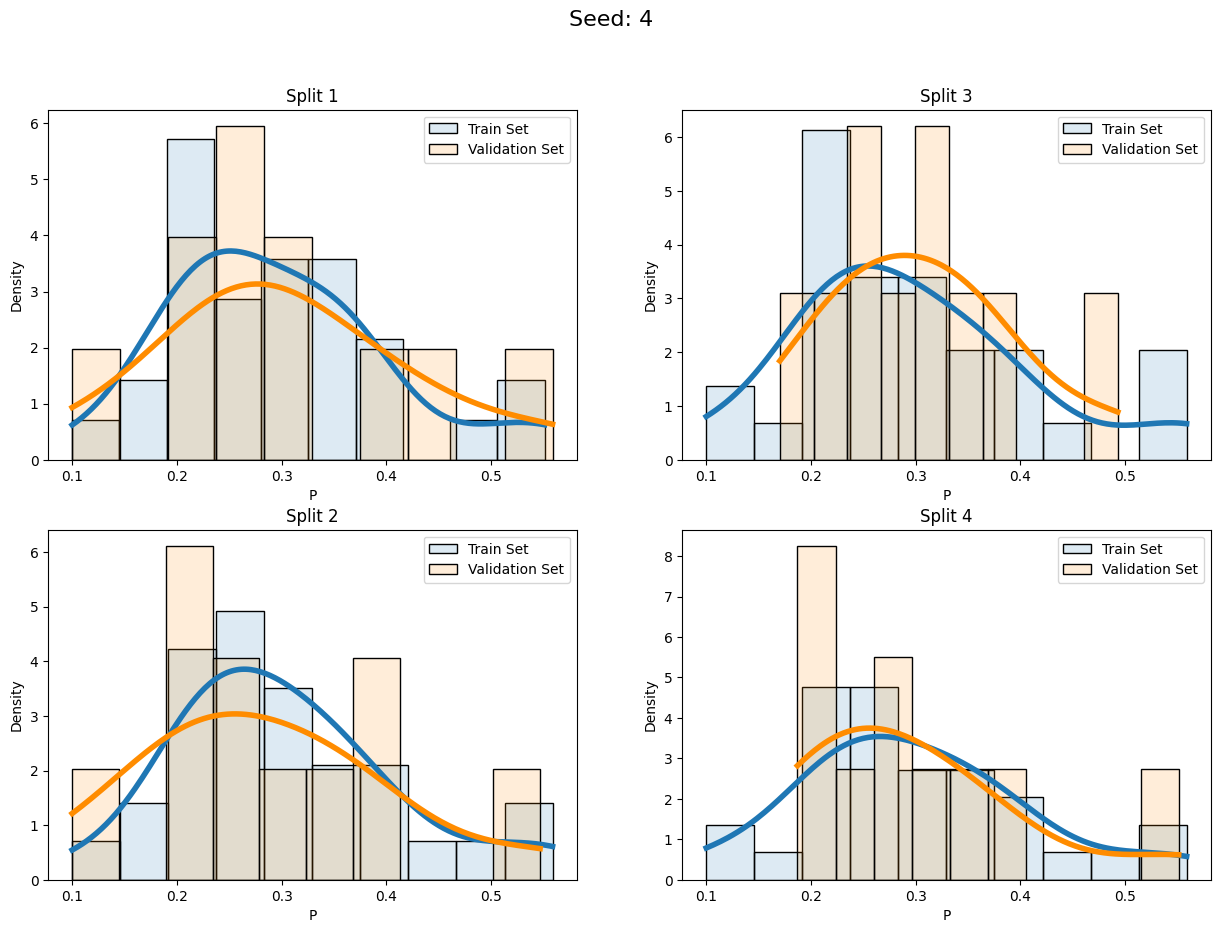

In [ ]:
num_of_folds = 4
num_of_groups = 5

cv_splits = create_cont_folds(target, n_s=num_of_folds, n_grp=num_of_groups, seed=4)
fold_visualizer(data=target,
                fold_idxs=cv_splits,
                seed_num=4)

In [ ]:
cv_splits = create_cont_folds(y, n_s=8, n_grp=10, seed=4)
x_tr = x.iloc[cv_splits[5][0]]
y_tr = y.iloc[cv_splits[5][0]]
x_te = x.iloc[cv_splits[5][1]]
y_te = y.iloc[cv_splits[5][1]]

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  warnings.warn(


# 9. Variable Selection

## 9.1. Boruta

In [ ]:
%%capture
!pip install BorutaShap
!pip install xgboost
!pip install lightgbm
!pip install catboost

In [ ]:
import catboost as cb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from BorutaShap import BorutaShap, load_data
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from  sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

### Random Forest

In [ ]:
selected_features = []

In [ ]:
forest = RandomForestRegressor(
   n_jobs = -1, n_estimators=200
)

Feature_Selector = BorutaShap(model=forest,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_tr, y=y_tr, n_trials=100, random_state=0)

selected_features += Feature_Selector.accepted
selected_features += Feature_Selector.tentative

  0%|          | 0/100 [00:00<?, ?it/s]

4 attributes confirmed important: ['B2 B3 bc(B7)^2 1/B6^2 1/bc(B4)', 'B2 B3 B5 bc(B6) 1/B6^3', 'B2 B4 B6 1/B1 1/B7 1/bc(B4)^2', 'B5^3 1/B1^2 1/B7 1/bc(B7)']
6 attributes confirmed unimportant: ['B5^2 bc(B3) bc(B7) 1/B7^2 1/bc(B4)', 'B3 B5 B6 1/B1^2 1/B7 1/bc(B4)', 'B2 B5 bc(B4)^2 1/B1 1/B4 1/B6', 'B5 B6^2 1/B1 1/bc(B6) 1/bc(B7)', 'B2 B5^2 1/B1 1/bc(B3) 1/bc(B4) 1/bc(B7)', 'B3 B5 B7 1/B2 1/B6 1/bc(B7)^2']
0 tentative attributes remains: []


### Gradient Boosting

In [ ]:
gb = GradientBoostingRegressor(
   n_estimators=200
)

Feature_Selector = BorutaShap(model=gb,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_tr, y=y_tr, n_trials=100, random_state=0)

selected_features += Feature_Selector.accepted
selected_features += Feature_Selector.tentative

  0%|          | 0/100 [00:00<?, ?it/s]

1 attributes confirmed important: ['B5^3 1/B1^2 1/B7 1/bc(B7)']
9 attributes confirmed unimportant: ['B5^2 bc(B3) bc(B7) 1/B7^2 1/bc(B4)', 'B3 B5 B6 1/B1^2 1/B7 1/bc(B4)', 'B2 B5 bc(B4)^2 1/B1 1/B4 1/B6', 'B2 B3 B5 bc(B6) 1/B6^3', 'B2 B3 bc(B7)^2 1/B6^2 1/bc(B4)', 'B5 B6^2 1/B1 1/bc(B6) 1/bc(B7)', 'B2 B5^2 1/B1 1/bc(B3) 1/bc(B4) 1/bc(B7)', 'B2 B4 B6 1/B1 1/B7 1/bc(B4)^2', 'B3 B5 B7 1/B2 1/B6 1/bc(B7)^2']
0 tentative attributes remains: []


### CatBoost

In [ ]:
ctb = CatBoostRegressor(iterations=200)

# no model selected default is Random Forest, if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=ctb,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_tr, y=y_tr, n_trials=100, random_state=0)

selected_features += Feature_Selector.accepted
selected_features += Feature_Selector.tentative

  0%|          | 0/100 [00:00<?, ?it/s]

3 attributes confirmed important: ['B2 B3 B5 bc(B6) 1/B6^3', 'B2 B4 B6 1/B1 1/B7 1/bc(B4)^2', 'B5^3 1/B1^2 1/B7 1/bc(B7)']
7 attributes confirmed unimportant: ['B5^2 bc(B3) bc(B7) 1/B7^2 1/bc(B4)', 'B3 B5 B6 1/B1^2 1/B7 1/bc(B4)', 'B2 B5 bc(B4)^2 1/B1 1/B4 1/B6', 'B2 B3 bc(B7)^2 1/B6^2 1/bc(B4)', 'B5 B6^2 1/B1 1/bc(B6) 1/bc(B7)', 'B2 B5^2 1/B1 1/bc(B3) 1/bc(B4) 1/bc(B7)', 'B3 B5 B7 1/B2 1/B6 1/bc(B7)^2']
0 tentative attributes remains: []


### XGBoost

In [ ]:
xgb = XGBRegressor(n_estimators=200)

# no model selected default is Random Forest, if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=xgb,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_tr, y=y_tr, n_trials=100, random_state=0)

selected_features += Feature_Selector.accepted
selected_features += Feature_Selector.tentative

  0%|          | 0/100 [00:00<?, ?it/s]

2 attributes confirmed important: ['B2 B4 B6 1/B1 1/B7 1/bc(B4)^2', 'B5^3 1/B1^2 1/B7 1/bc(B7)']
7 attributes confirmed unimportant: ['B5^2 bc(B3) bc(B7) 1/B7^2 1/bc(B4)', 'B3 B5 B6 1/B1^2 1/B7 1/bc(B4)', 'B2 B5 bc(B4)^2 1/B1 1/B4 1/B6', 'B2 B3 bc(B7)^2 1/B6^2 1/bc(B4)', 'B5 B6^2 1/B1 1/bc(B6) 1/bc(B7)', 'B2 B5^2 1/B1 1/bc(B3) 1/bc(B4) 1/bc(B7)', 'B3 B5 B7 1/B2 1/B6 1/bc(B7)^2']
1 tentative attributes remains: ['B2 B3 B5 bc(B6) 1/B6^3']


In [ ]:
selected_features = list(dict.fromkeys(selected_features))

x_tr = x_tr[selected_features]
x_te = x_te[selected_features]
df = x[selected_features].copy()
df['P'] = y

In [ ]:
eigenvectors = pca.components_
eigenvectors = [eigenvectors[1]]
variables = poly_df.columns  # Adjust this based on your actual variable names

for i, comp in enumerate(eigenvectors):
    terms = [f"{comp[j]:.3f}*{variables[j]}" for j in range(len(variables)) if round(comp[j],3) != 0]
    formula = " + ".join(terms)
    print(f"Principal Component {i+1}: {formula}")

NameError: name 'pca' is not defined

# 10. Bivariate analysis / correlation between data

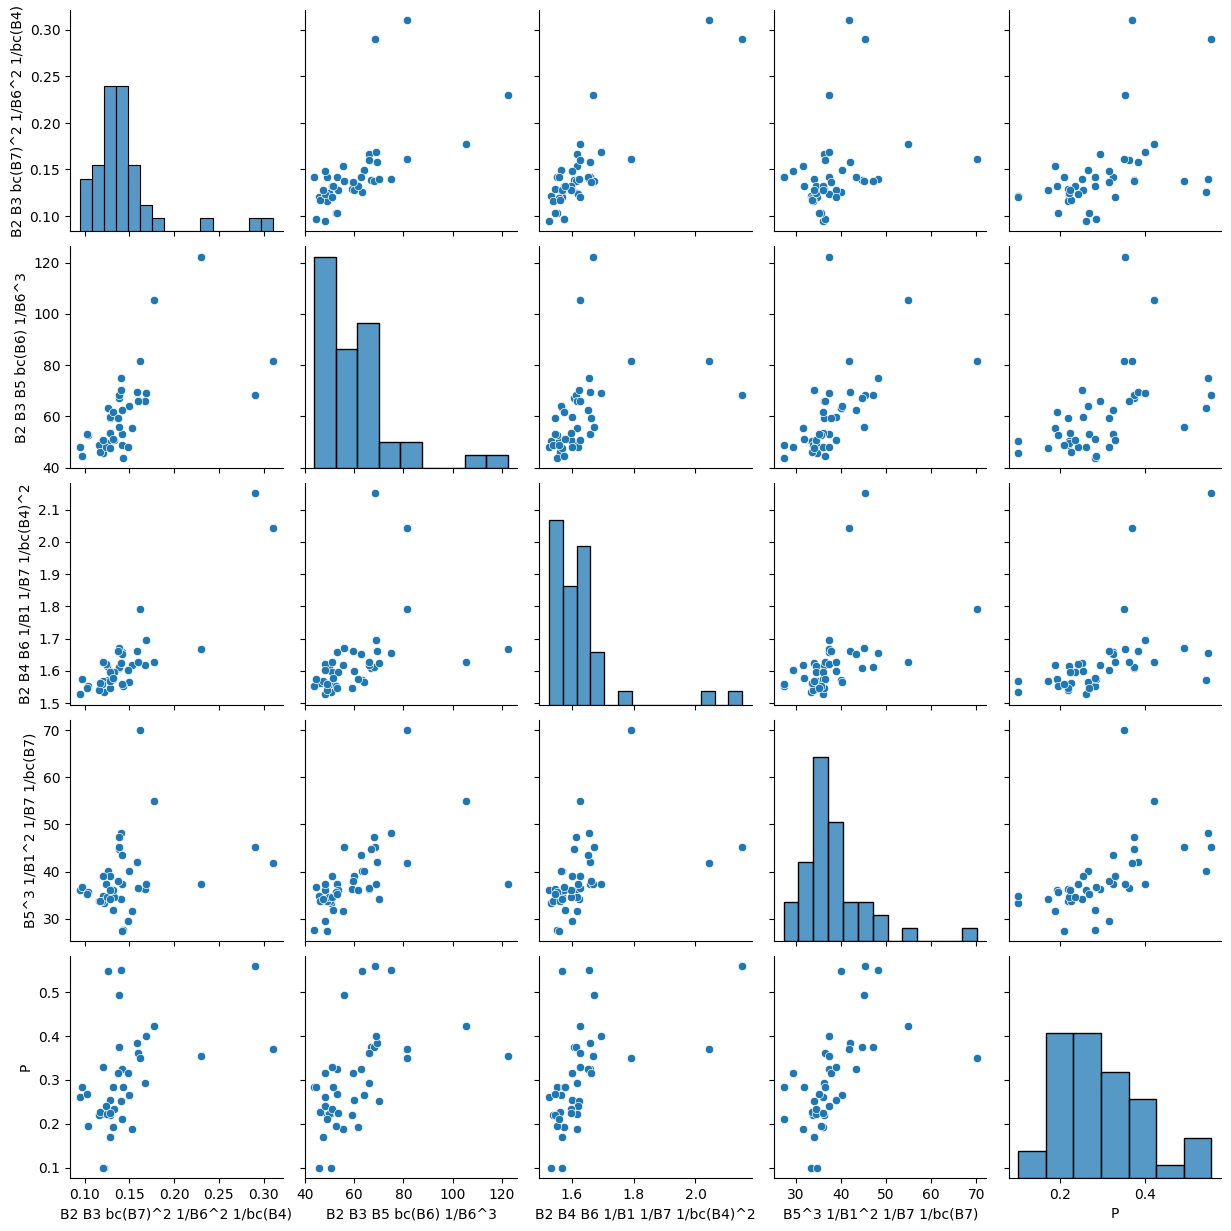

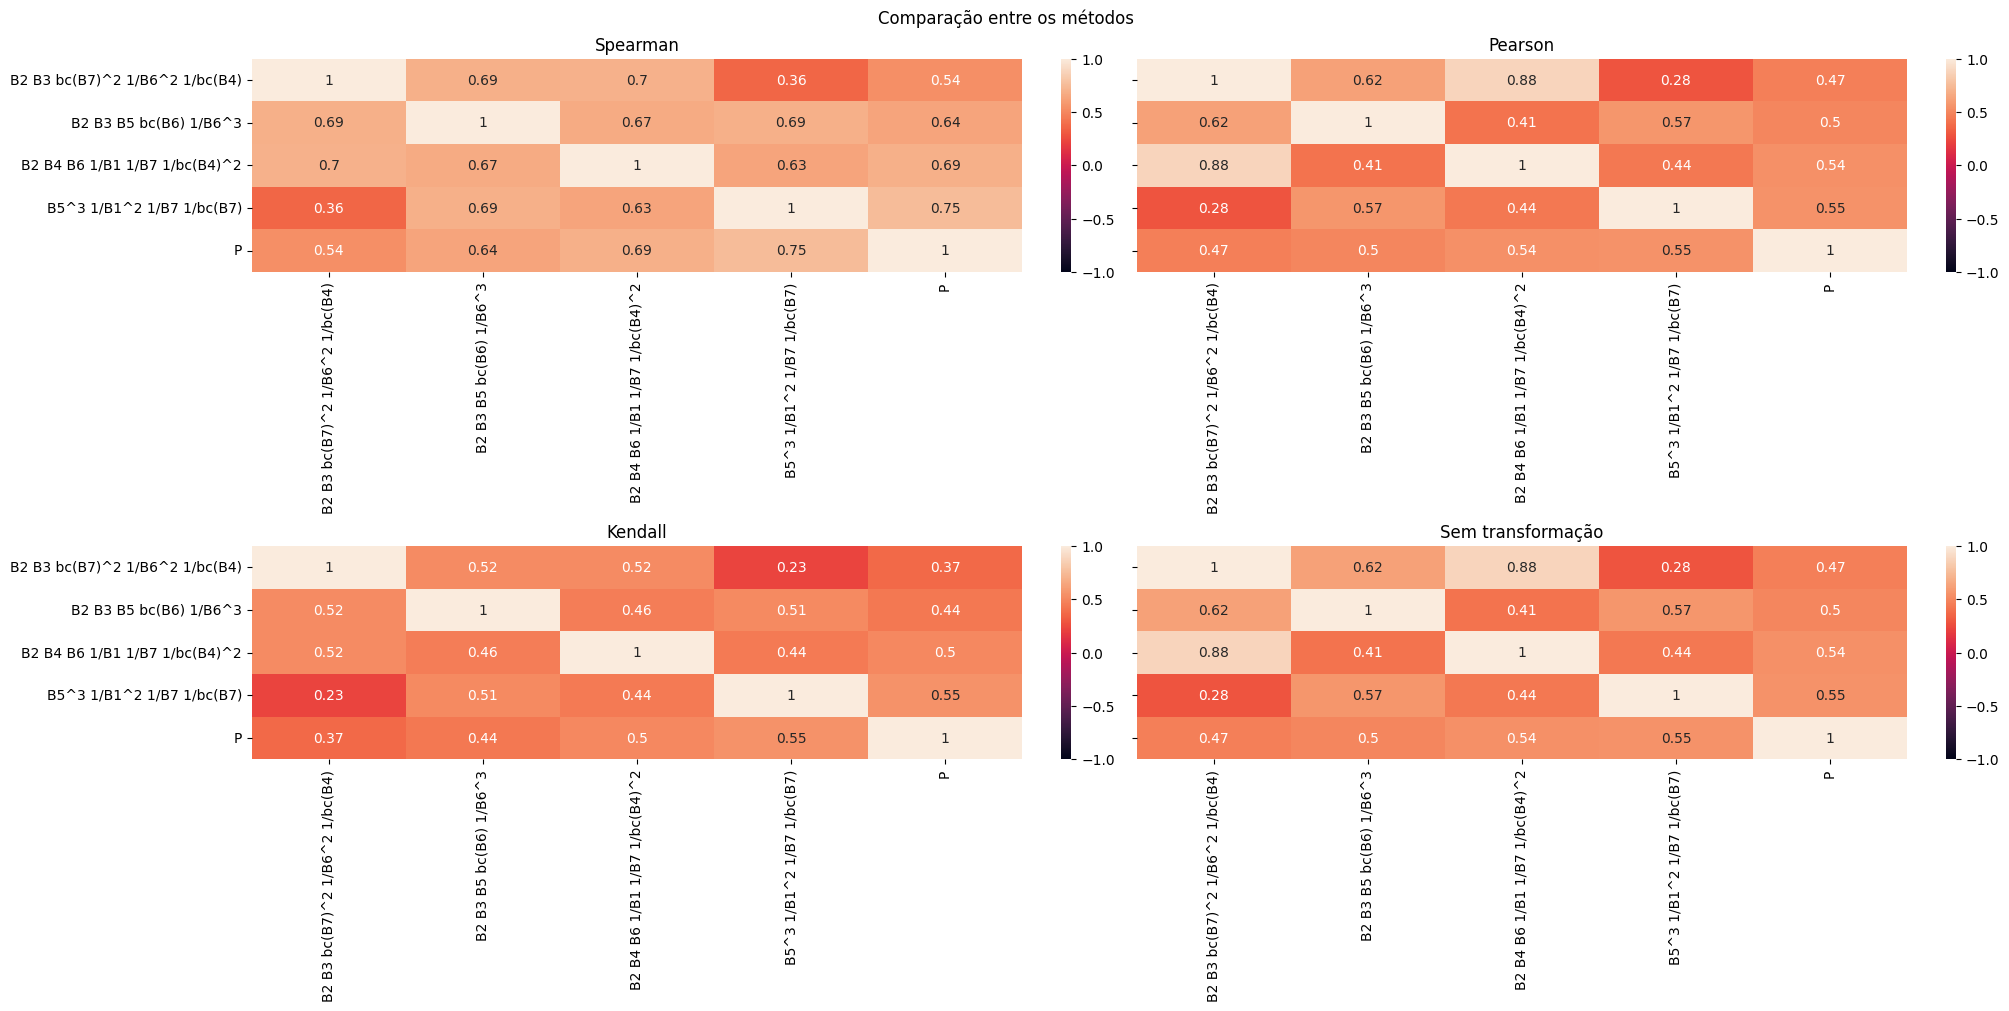

In [ ]:
sns.pairplot(df)
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=True, constrained_layout=True)
fig.suptitle('Comparação entre os métodos')

#Spearman
ax = sns.heatmap(df.corr(method='spearman'), annot=True, vmin=-1, vmax=1, ax = axes[0,0])
axes[0,0].set_title("Spearman")
bottom, top = ax.get_ylim()

#Pearson
ax = sns.heatmap(df.corr(method='pearson'), annot=True, vmin=-1, vmax=1, ax = axes[0,1])
axes[0,1].set_title("Pearson")
bottom, top = ax.get_ylim()

#Kendall
ax = sns.heatmap(df.corr(method='kendall'), annot=True, vmin=-1, vmax=1, ax = axes[1,0])
bottom, top = ax.get_ylim()
axes[1,0].set_title("Kendall")

#Sem transformação
ax = sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, ax = axes[1,1])
axes[1,1].set_title("Sem transformação")
bottom, top = ax.get_ylim()

# 11. Regression Algorithms

In [ ]:
def plot_results(y_pred, y_tes):
  plt.rcParams["figure.figsize"] = (10,5)
  plt.scatter(range(len(y_pred)), y_pred, c='r')
  plt.plot(range(len(y_tes)), y_tes, linestyle="-", marker="o", label="Expenses")
  plt.title('Model performance - test set')
  plt.ylabel('P medido')
  plt.xlabel('Sample')
  plt.legend(['predicted', 'real'], loc='upper left')
  plt.show()

Before we implement the regression models, I would like to clarify that we will use two main metrics to evaluate the performance of our models:


  * Mean Absolute Percentage Error (MAPE):
  \begin{equation}
    MAPE = \frac{1}{n} \sum_{i = 1}^{n} \frac{|y_i - p_i|}{y_i}
  \end{equation}

  * Mean Absolute Error (MAE):
  \begin{equation}
    MAE = \frac{1}{n} \sum_{i = 1}^{n} |y_i - p_i|
  \end{equation}

  * $R^2$ score:
  \begin{equation}
    R^2 = NSE = 1 - \frac{\sum_{i=1}^{N} (y_i - p_i)^2}{\sum_{i=1}^{N} (y_i - \bar{y_i})^2}
  \end{equation}


Where $y_i$ is the actual value, $p_i$ is the value predicted by the tested model, and $\bar{y_i}$ is the average of the $y_i$ values, $\forall i$.


## 11.1. Linear Methods

In [ ]:
import sklearn.model_selection as skms
import sklearn.linear_model as sklm
import sklearn as sk
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.metrics import make_scorer

In [ ]:
def inverse_box_cox(y, lambda_):
  if lambda_ == 0:
    return np.exp(y)
  else:
    return np.log(1 + lambda_*y)/np.log(lambda_)

def inverse_square_root(y):
  return y**2

In [ ]:
def cross_validation(x_train, y_train, folds, lambda_=None):

  splits = create_cont_folds(y_train, n_s=folds, n_grp=10, seed=4)
  x_tr = np.array(x_train)
  y_tr = np.array(y_train)
  histories = []
  models = []
  results = []


  for train_index, test_index in splits:
    xtr, xva = x_tr[train_index], x_tr[test_index]
    ytr, yva = y_tr[train_index], y_tr[test_index]

    model = sklm.LinearRegression()
    model.fit(xtr, ytr)
    y_pred = model.predict(xva)

    if lambda_ !=None:
      y_pred = inverse_square_root(y_pred)
      yva = inverse_square_root(yva)


    r2 = r2_score(yva, y_pred)
    mae = mean_absolute_error(yva, y_pred)
    mape = mean_absolute_percentage_error(yva, y_pred)
    mse = mean_squared_error(yva, y_pred)
    result = {'r2':r2, 'mae':mae, 'mape':mape, 'mse':mse}
    results.append(result)

  return results

In [ ]:
def train_test_model(model, x_tr, y_tr, x_te, y_te, lambda_=None, folds=5):
  scores = cross_validation(x_tr, y_tr, folds=folds, lambda_=lambda_)

  mae = np.mean([val['mae'] for val in scores])
  std_mae = np.std([val['mae'] for val in scores])

  mape = np.mean([val['mape'] for val in scores])
  std_mape = np.std([val['mape'] for val in scores])

  mse = np.mean([val['mse'] for val in scores])
  std_mse = np.std([val['mse'] for val in scores])

  r2 = np.mean([val['r2'] for val in scores])
  std_r2 = np.std([val['r2'] for val in scores])

  print('--------------------Validação Cruazada-----------------------')
  print("Média dos valore de MAE: " + str(mae))
  print("Desvio padrão dos valore de MAE: " + str(std_mae) + "\n")

  print("Média dos valore de MAPE: " + str(mape))
  print("Desvio padrão dos valore de MAPE: " + str(std_mape) + "\n")

  print("Média dos valore de MSE: " + str(mse))
  print("Desvio padrão dos valore de MSE: " + str(std_mse) + "\n")

  print("Média dos valore de R2: " + str(r2))
  print("Desvio padrão dos valore de R2: " + str(std_r2) + "\n")

  print('--------------------Teste-----------------------')
  model.fit(x_tr, y_tr)
  y_pred = model.predict(x_te)

  if lambda_ !=None:
      y_pred = inverse_square_root(y_pred)
      y_te = inverse_square_root(y_te)

  print("MAE: " + str(mean_absolute_error(y_te, y_pred)))
  print("MAPE: " + str(mean_absolute_percentage_error(y_te, y_pred)))
  print("MSE: " + str(mean_squared_error(y_te, y_pred)))
  print("R2: " + str(r2_score(y_te, y_pred)))

  plot_results(y_pred, y_te)

### 11.2.1. Linear Regression

**Using only train set**

--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 0.053511934196055634
Desvio padrão dos valore de MAE: 0.02754877119523546

Média dos valore de MAPE: 0.7136978125068589
Desvio padrão dos valore de MAPE: 0.2031521442370898

Média dos valore de MSE: 0.008688721497783408
Desvio padrão dos valore de MSE: 0.011145383347799943

Média dos valore de R2: -6.177026509330715
Desvio padrão dos valore de R2: 16.450145297377645

--------------------Teste-----------------------
MAE: 0.03229725114624291
MAPE: 0.49546012938707984
MSE: 0.0024305439163588727
R2: 0.5520927003936131


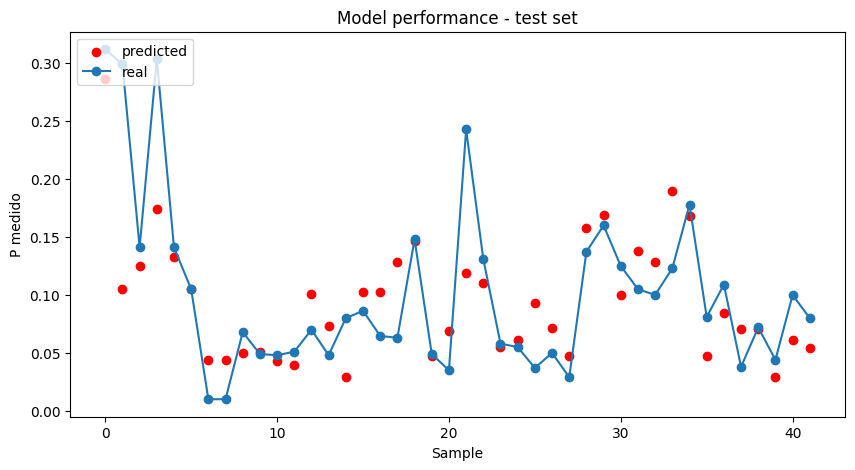

In [ ]:
linear_regressor = sklm.LinearRegression()
train_test_model(linear_regressor, x, y, x, y, lambda_=0, folds=8)

**Using train and test sets**

--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 0.054169430525834346
Desvio padrão dos valore de MAE: 0.014019695194168826

Média dos valore de MAPE: 0.6161978729303722
Desvio padrão dos valore de MAPE: 0.21963773805846643

Média dos valore de MSE: 0.007992182858722179
Desvio padrão dos valore de MSE: 0.00527289193522593

Média dos valore de R2: -0.35081211765311815
Desvio padrão dos valore de R2: 0.8255983009986556

--------------------Teste-----------------------
MAE: 0.019723366780817098
MAPE: 1.0817734504775594
MSE: 0.000733804375126393
R2: 0.6573185381596776


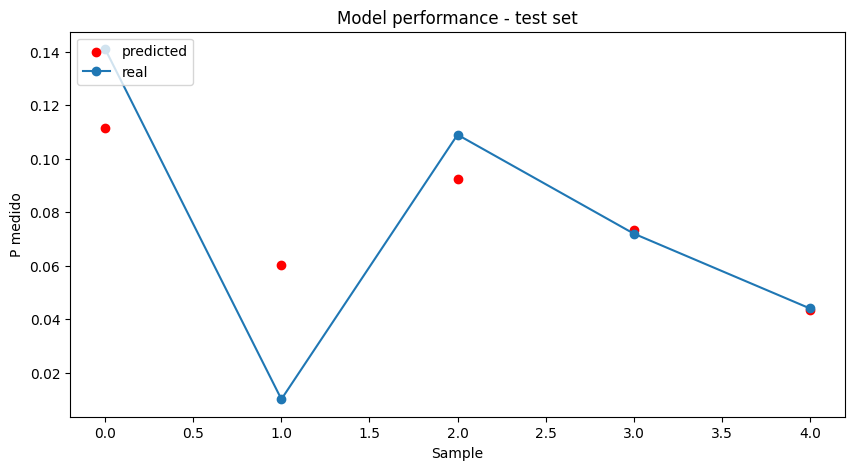

In [ ]:
linear_regressor = sklm.LinearRegression()
train_test_model(linear_regressor, x_tr, y_tr, x_te, y_te, lambda_=0, folds=4)

In [ ]:
print("Coeficientes da regressão linear: " + str(linear_regressor.coef_))

Coeficientes da regressão linear: [-1.1941525   0.0027002   0.66944712  0.0016507 ]


### 11.2.2. Ridge Regression

In [ ]:
ray.init()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
# definindo espaço de busca para os lambdas
lambdas = np.linspace(0, 1000000, 10000)

**5-Folds**

In [ ]:
@ray.remote

def test_lambda(lamb):
  # aplicando a regressão
  ridge = sklm.Ridge(alpha = lamb)
  ridge.fit(x_tr, y_tr)             # Fit a ridge regression on the training data

  scores = skms.cross_validate(ridge, x_tr, y_tr, cv=5,
                               scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'))

  mae = np.mean(scores['test_neg_mean_absolute_error']*(-1))
  mape = np.mean(scores['test_neg_mean_absolute_percentage_error']*(-1))
  r2 = np.mean(scores['test_r2'])

  return [mae, mape, r2]

In [ ]:
result_values = ray.get([test_lambda.remote(i) for i in lambdas])
scores_MAE = [result[0] for result in result_values]
scores_MAPE = [result[1] for result in result_values]
scores_R2 = [result[2] for result in result_values]

In [ ]:
best_index = scores_MAE.index(min(scores_MAE))

print("Lambda:" + str(lambdas[best_index]))
print("Best MAE: " + str(scores_MAE[best_index]))
print("Best MAPE: " + str(scores_MAPE[best_index]))
print("R2: " + str(scores_R2[best_index]))

ridge = sklm.Ridge(alpha = lambdas[best_index])
ridge.fit(x_tr, y_tr)
plot_results(ridge.predict(x_te), y_te)

**10-folds**

In [ ]:
@ray.remote

def test_lambda(lamb):
  # aplicando a regressão
  ridge = sklm.Ridge(alpha = lamb)
  ridge.fit(x_tr, y_tr)             # Fit a ridge regression on the training data

  scores = skms.cross_validate(ridge, x_tr, y_tr, cv=10,
                               scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'))

  mae = np.mean(scores['test_neg_mean_absolute_error']*(-1))
  mape = np.mean(scores['test_neg_mean_absolute_percentage_error']*(-1))
  r2 = np.mean(scores['test_r2'])

  return [mae, mape, r2]

In [ ]:
result_values = ray.get([test_lambda.remote(i) for i in lambdas])
scores_MAE = [result[0] for result in result_values]
scores_MAPE = [result[1] for result in result_values]
scores_R2 = [result[2] for result in result_values]

In [ ]:
best_index = scores_MAE.index(min(scores_MAE))

print("Lambda:" + str(lambdas[best_index]))
print("Best MAE: " + str(scores_MAE[best_index]))
print("Best MAPE: " + str(scores_MAPE[best_index]))
print("R2: " + str(scores_R2[best_index]))

ridge = sklm.Ridge(alpha = lambdas[best_index])
ridge.fit(x_tr, y_tr)
plot_results(ridge.predict(x_te), y_te)

In [ ]:
y_pred = ridge.predict(x_te)
print('-----------Teste-------------')
print("MAE: " + str(mean_absolute_error(y_te, y_pred)))
print("MAPE: " + str(mean_absolute_percentage_error(y_te, y_pred)))
print("R2: " + str(r2_score(y_te, y_pred)))

## 11.2 Non-linear Methods

### 11.2.1. SVM

In [ ]:
from sklearn import svm

**5-Folds**

In [ ]:
svm_regressor = svm.SVR()
train_test_model(svm_regressor, x_tr, y_tr, x_te, y_te, folds=5)

**10-Folds**

In [ ]:
train_test_model(svm_regressor, x_tr, y_tr, x_te, y_te, folds=10)

### 11.2.2. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor as rf

In [ ]:
rf_regressor = rf(n_estimators=1000, random_state=1)
rf_regressor.fit(x_tr, y_tr)

**5-Folds**

In [ ]:
train_test_model(rf_regressor, x_tr, y_tr, x_te, y_te, folds=5)

**10-Folds**

In [ ]:
train_test_model(rf_regressor, x_tr, y_tr, x_te, y_te, folds=10)

### 11.2.3 Gradient Boost

In [ ]:
import catboost as cb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from  sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [ ]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [2, 3, 5, 7, 10],
        'min_samples_split': [2, 5, 10, 20],
        'max_features': ['log2', 0.25, 'sqrt', 1.0],
        'subsample': [0.15, 0.5, 0.75, 1.0]}

clf = GridSearchCV(GradientBoostingRegressor(n_estimators=200), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_tr)
clf.best_params_

In [ ]:
gb = GradientBoostingRegressor(n_estimators=200,learning_rate=0.025,
 max_depth=3,
 max_features='log2',
 min_samples_split=2,
 subsample=0.15
)


train_test_model(gb, x_tr, y_tr, x_te, y_te, folds=10)

### 11.2.4 CatBoost

In [ ]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [3, 6, 9],
        'leaf_estimation_iterations': [1, 10],
        'l2_leaf_reg': [1, 3, 6, 9]}

clf = GridSearchCV(CatBoostRegressor(iterations=200), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_tr)
clf.best_params_

In [ ]:
ctb = CatBoostRegressor(n_estimators=200,l2_leaf_reg= 1,
 leaf_estimation_iterations= 10,
 learning_rate= 0.3,
 max_depth= 6)


train_test_model(ctb, x_tr, y_tr, x_te, y_te, folds=10)

In [ ]:
ctb.get_feature_importance(prettified=True)

### 11.2.5 XGBoost

In [ ]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [2, 3, 5, 7, 10, 100],
        'gamma':[0, 0.1, 0.2, 0.3, 0.4, 1.0, 1.5, 2.0],
        'colsample_bylevel': ['log2', 'sqrt', 0.25, 1.0],
        'subsample': [0.15, 0.5, 0.75, 1.0]}

clf = GridSearchCV(XGBRegressor(n_estimators=200), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_tr)
clf.best_params_

In [ ]:
xgb = XGBRegressor(n_estimators=200,colsample_bylevel=0.25,
 gamma=0,
 learning_rate=0.025,
 max_depth=10,
 subsample=0.15
)


train_test_model(ctb, x_tr, y_tr, x_te, y_te, folds=10)

In [ ]:
%%capture
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%writefile no_code.tpl
{% extends 'article.tplx' %}

{% block input_group %}
{% endblock input_group %}

In [ ]:
!cp /content/drive/MyDrive/CNN_Chagas/fosforo/Cópia_de_Analise_fosforo.ipynb ./

In [ ]:
!jupyter nbconvert --to pdf  "Cópia_de_Analise_fosforo.ipynb"